In [4]:
import numpy as np
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
%matplotlib inline

In [47]:

# Behavioral DATA
fold_g = 'F:/IRM_Marche/'
smt='ss'       
names='ap','as','boh','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
label=np.loadtxt(fold_g+'label_main.txt','S12')
block=np.loadtxt(fold_g+'block_main.txt','int')
motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_whole70_basc444asym.np','int')
index=np.array((10,35,47,50,52,67,69,70,80,89,91,95,108,110,111,121,124,126,139,142,144,148,154,176,184,191,195,199,200,
               201,206,213,218,233,244,257,264,266,267,268,273,275,279,281,283,285,287,299,303,336,344,351,363,365,
               378,381,387,403,432))
sma=np.array((428,89,437,424,230,67,392))
imag=np.array((268,344,67,154,275,35,257,52,213,273,403,432,266,10,195,126,283,89))
stim=np.array((285,387,108,279,381,121,200,378,206,299,69,144,148,50))
hand=np.array((47,264,365,303,351,281,154,244,432,267,199,257,111,70,287,89,124,110,201,69))
foot=np.array((108,91,80,403,52,218,176,50,191,233,378,336,195,184,363,95,139,142))

motor_region=np.sort(index)
n_loop=motor_region.shape[0]
# Remove data not analysed
mask_block=block==block
for x in range(label.shape[0]):
    if label[x,2]!=label[x-1,2]:
        mask_block[x]=False
    elif label[x,2]!=label[x-2,2]:
        mask_block[x]=False
c_des_out=np.logical_not(label[:,2]== b'des')
tmp_out= np.logical_and(c_des_out,mask_block)
c_rest_out=np.logical_not(label[:,0]== b'rest')
cond_out= np.logical_and(tmp_out,c_rest_out)
y=label[cond_out,2]
labels=np.unique(y)
# Prepare correlation
#estimator = LedoitWolf()
estimator = EmpiricalCovariance()
scaler=StandardScaler()
# Create np array
result_matrix = np.empty([len(names),motor_region.shape[0],labels.shape[0],labels.shape[0]])

#Analysis for each subject
for i,n in enumerate(sorted(names)):
    roi_name=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'   
    roi=np.load(roi_name)['roi'][cond_out]
    roi=roi[:,motor_region-1] 
    for j in range(motor_region.shape[0]):
        roi_j=roi[:,j]
        roi_mat=np.zeros(((y==b'imp').sum(),len(labels)))
        for z,lab in enumerate(sorted(labels)):
            roi_mat[:,z]=roi_j[y==lab]           
        roi_sc=scaler.fit_transform(roi_mat) 
        estimator.fit(roi_sc)
        matrix=estimator.covariance_ 
        result_matrix[i,j]=1-matrix


Sanity check on RDM matrices

In [34]:
result_matrix.shape

(23, 59, 4, 4)

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

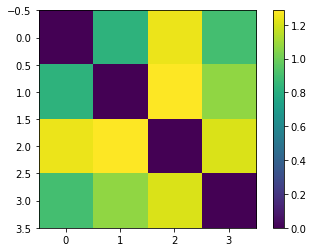

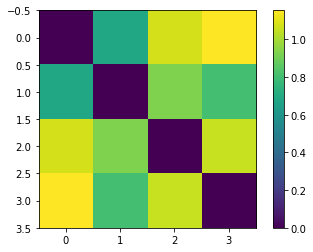

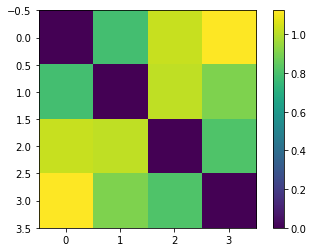

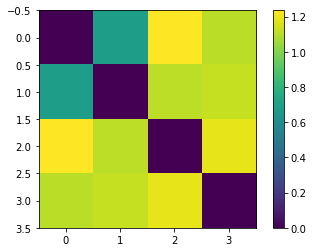

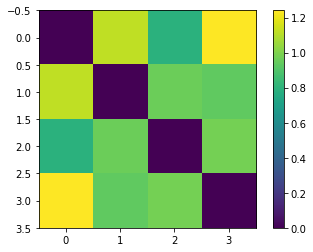

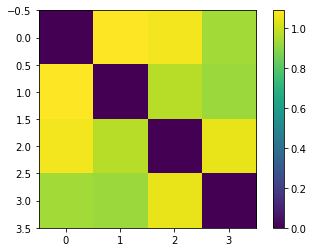

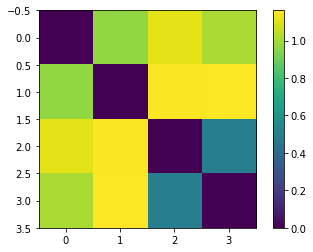

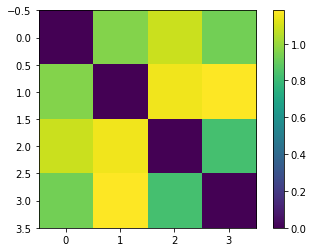

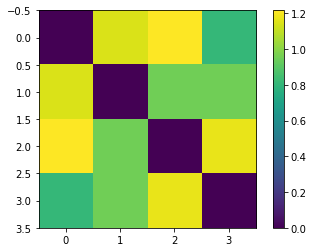

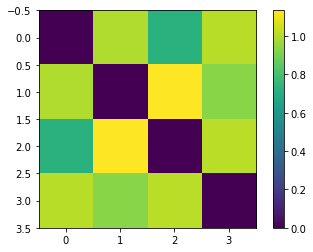

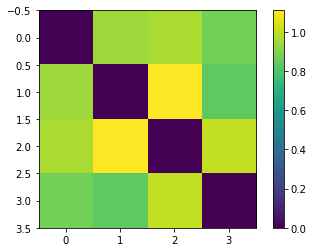

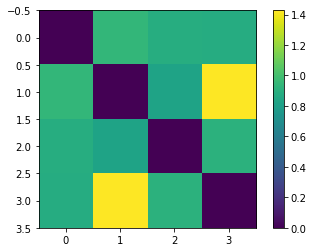

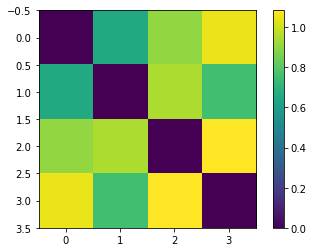

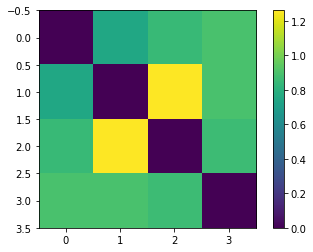

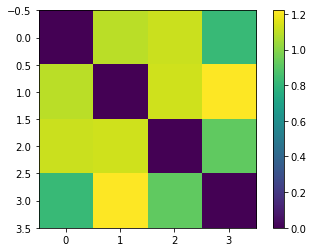

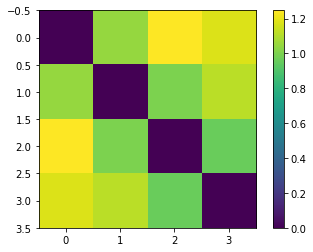

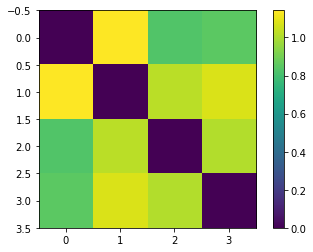

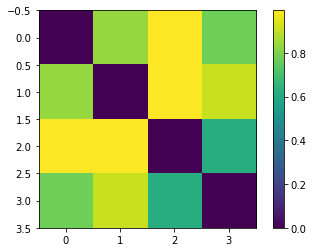

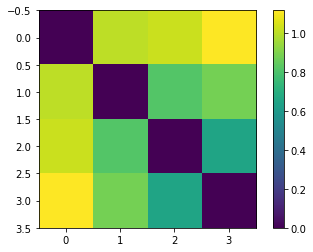

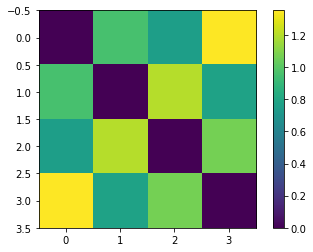

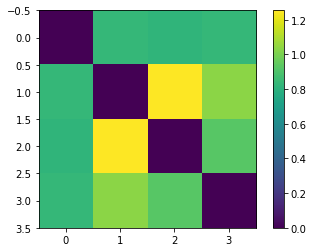

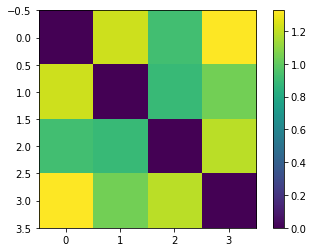

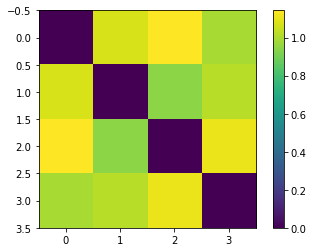

In [36]:
for c in result_matrix:
    plt.imshow(c[0],interpolation='nearest')
    plt.colorbar()
    plt.show()

Summarizing across subjects (grand average)

In [48]:
RDM_matrices_grav = result_matrix.mean(axis=0)
print(RDM_matrices_grav.shape)
RDM_matrix_av=RDM_matrices_grav.mean(axis=0)
print(RDM_matrix_av.shape)

(59, 4, 4)
(4, 4)


In [41]:
from sklearn.manifold import MDS

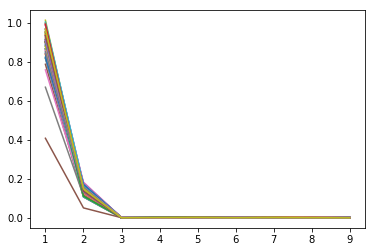

In [42]:

for reg in range(n_loop):
    allstress = []
    for k in range(1,10):
        mymds = MDS(dissimilarity='precomputed',n_components=k)
        mymds.fit(RDM_matrices_grav[reg])
        allstress.append(mymds.stress_)
    
    plt.plot(range(1,10),allstress)

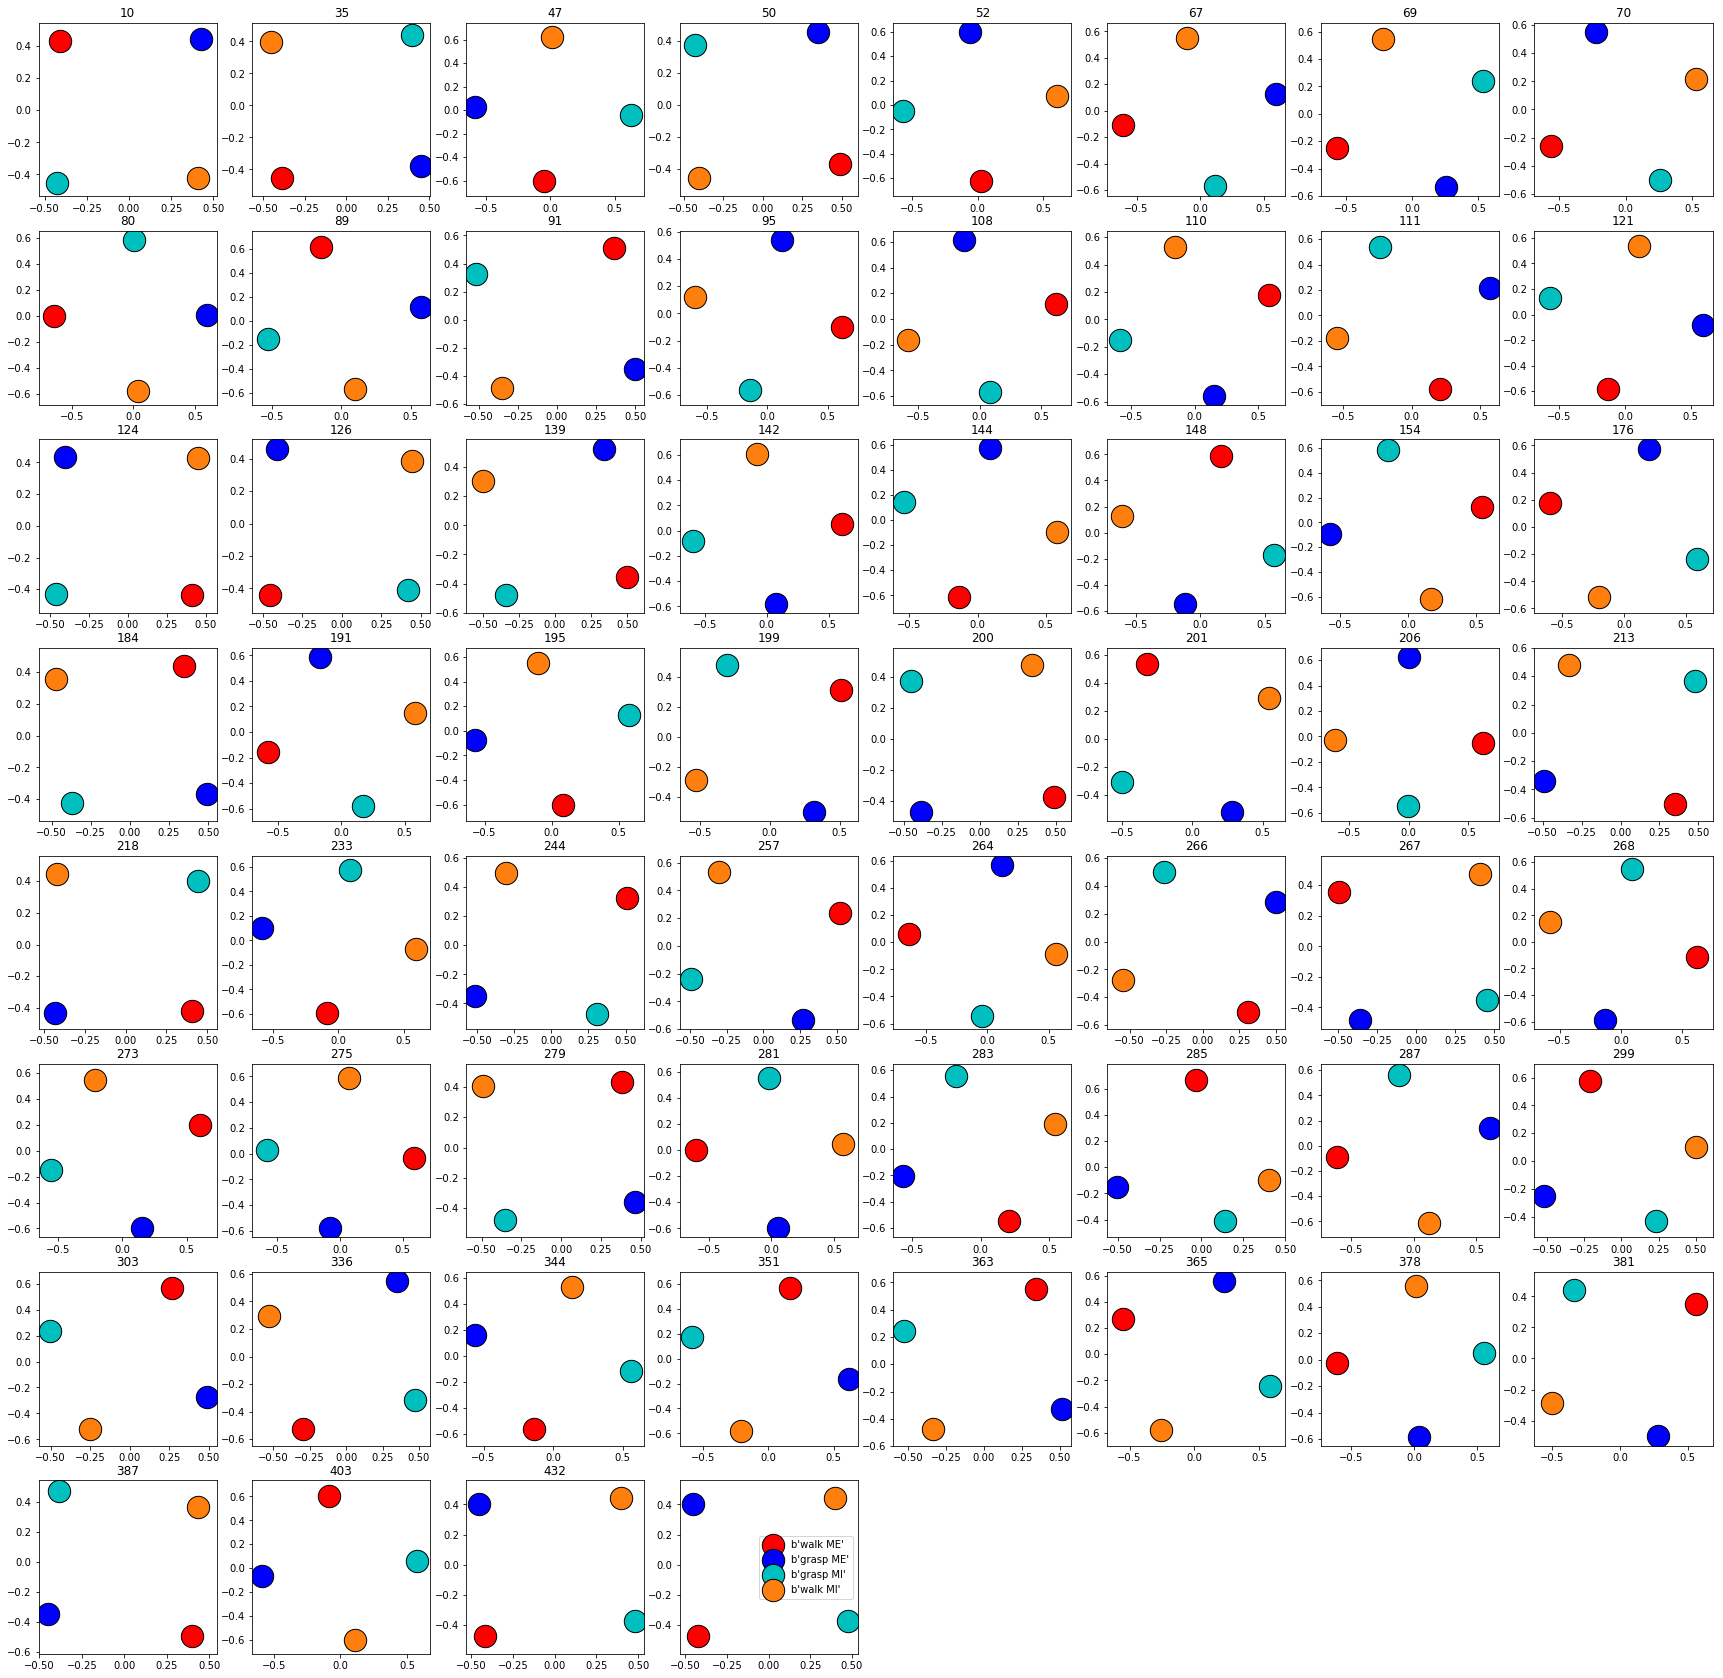

In [68]:
from sklearn.manifold import MDS
from math import sqrt
ncompmds = 2
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

colors = ['r', 'b','c','tab:orange']
names = sorted(labels)
names =[w.replace(b'imp', b'walk ME') for w in names]
names =[w.replace(b'mboug', b'grasp ME') for w in names]
names =[w.replace(b'mimag', b'grasp MI') for w in names]
names =[w.replace(b'pimag', b'walk MI') for w in names]
size=500
nsub=int(sqrt(n_loop))
fig=plt.figure(figsize=(30,30))
for nroi in range(n_loop) : #range(184):
    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
    ax = fig.add_subplot(nsub+1, nsub+1, nroi+1) # this line adds sub-axes
    for i,color in enumerate(colors):
        name=names[i]        
        ax.scatter(mds_res[i, 0], mds_res[i, 1], s=size,
               facecolors=color, label=name, edgecolors='k',)
    ax.set_title(str(motor_region[nroi]))
ax = fig.add_subplot(nsub+1, nsub+1, nroi+2) # this line adds sub-axes
for i,color in enumerate(colors):
        name=names[i]        
        ax.scatter(mds_res[i, 0], mds_res[i, 1], s=size,
               facecolors=color, label=name, edgecolors='k',)
        
ax.legend()

fig.savefig('Z:/GitHub/irm_marche/result_rsa_reg.png')

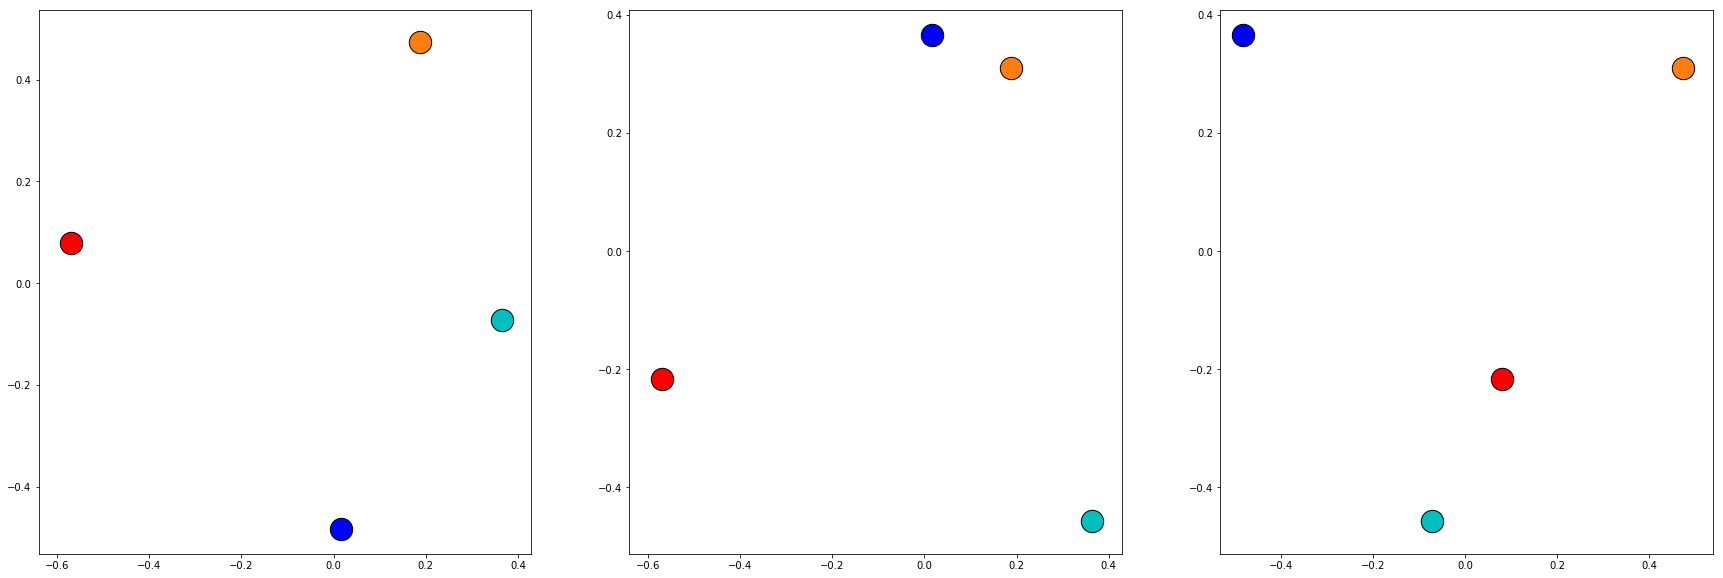

In [67]:
ncompmds = 3
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)


mds_res = mymds.fit_transform(RDM_matrix_av)
fig=plt.figure(figsize=(30,10))


for i,color in enumerate(colors):
    name=names[i]  
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(mds_res[i, 0], mds_res[i, 1], s=size,
               facecolors=color, label=name, edgecolors='k',)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(mds_res[i, 0], mds_res[i, 2], s=size,
               facecolors=color, label=name, edgecolors='k',)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(mds_res[i, 1], mds_res[i, 2], s=size,
               facecolors=color, label=name, edgecolors='k',)

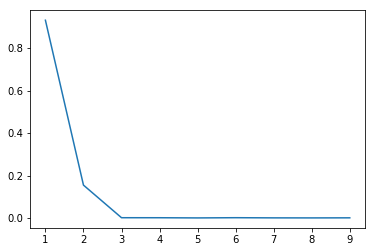

In [61]:
allstress = []
for k in range(1,10):
    mymds = MDS(dissimilarity='precomputed',n_components=k)
    mymds.fit(RDM_matrix_av)
    allstress.append(mymds.stress_)
    
plt.plot(range(1,10),allstress)

In [13]:
str(motor_region[nroi])

'432'

In [14]:
 mds_res.shape

(4, 2)

In [15]:
nroi

58

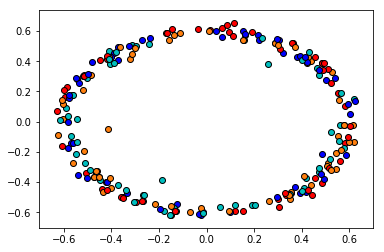

In [16]:
from sklearn.manifold import MDS
ncompmds = 2
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

plt.figure()
for nroi in range(n_loop):
    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
    for i,color in enumerate(colors):
        name=names[i]
        plt.scatter(mds_res[i, 0], mds_res[i, 1], 
               facecolors=color, label=name, edgecolors='k',)
#plt.figure()
#for nroi in range(184):
#    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
#    for i,color in enumerate(colors):
#        name=names[i]
 #       plt.scatter(mds_res[i, 0], mds_res[i, 2], 
#               facecolors=color, label=name, edgecolors='k',)
#plt.figure()
#for nroi in range(184):
#    mds_res = mymds.fit_transform(RDM_matrices_grav[nroi])
#    for i,color in enumerate(colors):
#        name=names[i]
#        plt.scatter(mds_res[i, 1], mds_res[i, 2], 
 #              facecolors=color, label=name, edgecolors='k',)

In [17]:
from networkx.convert_matrix import from_numpy_matrix

In [18]:
G = from_numpy_matrix(RDM_matrices_reduced_grav.mean(axis=0))

NameError: name 'RDM_matrices_reduced_grav' is not defined

In [ ]:
posdict = G.node_dict_factory({0:mds_res[0],1:mds_res[1],2:mds_res[2],3:mds_res[3]})

In [ ]:
from networkx.drawing.nx_pylab import draw

draw(G,posdict)